In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import json
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('datasets/combined.csv')
num = ['Current Loan Amount', 'Credit Score', 'Annual Income', 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts', 'Current Credit Balance', 'Maximum Open Credit']
cate = ['Term', 'Years in current job', 'Home Ownership', 'Purpose', 'Number of Credit Problems', 'Bankruptcies', 'Tax Liens']
target = 'Loan Status'

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

scaler = StandardScaler()
data[num] = scaler.fit_transform(data[num])

ohe = OneHotEncoder(sparse=False)
ohe_data = ohe.fit_transform(data[cate])
feature_names = ohe.get_feature_names_out(cate)
ohe_df = pd.DataFrame(ohe_data, columns=feature_names)

pred = pd.concat([data[num], ohe_df], axis=1)
pred.head()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Current Credit Balance,Maximum Open Credit,Term_Long Term,Term_Short Term,...,Purpose_Small Business,Purpose_Take a Trip,Purpose_Vacation,Purpose_Wedding,Number of Credit Problems_0,Number of Credit Problems_>= 1,Bankruptcies_0,Bankruptcies_>= 1,Tax Liens_0,Tax Liens_>= 1
0,0.785256,-0.287916,-0.206719,-1.130710,-0.075000,-1.023820,-0.109559,-0.319168,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.240210,0.136230,-0.648519,-0.816379,-0.856869,-0.397137,0.035061,-0.407626,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.484801,0.454339,-0.186254,-0.628059,0.285862,0.438441,-0.654448,-0.748851,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,1.361462,-1.383625,1.498528,0.067518,0.736940,-1.441609,0.964498,0.091505,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,-0.494247,0.772448,0.145259,1.904886,-0.571186,1.900703,2.158861,1.476592,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    pred,
    data['Loan Status'],
    test_size=0.2,
    random_state=0
)

In [5]:
def create_model(hidden_layer_units, input_dim, dropout=False, dropout_rate=0.2, model_name='model'):
    """
    Creates a neural network classifier model with:
        - l hidden layers, where l is len(hidden_layer_units)
        - hidden_layer_units[i] units for i'th layer
        - Binary Crossentropy loss
        - Adam optimizer
        - Accuracy, precision, and recall metrics
        - Dropout in each layer (optional)
        - Model name model_name
    
    Returns the compiled model.
    """
    
    model = Sequential(name=model_name)
    
    # Input layer
    model.add(Dense(hidden_layer_units[0], 
                    activation='relu', 
                    input_dim=input_dim,
                    name='Dense_1'))
    
    if dropout == True:
        model.add(Dropout(dropout_rate, name='Dropout_1'))    
    
    # Add the hidden layers
    l = 2
    for units in hidden_layer_units[1:]:
        model.add(Dense(units, activation='relu', name=f'Dense_{l}'))
        l += 1
        
        if dropout == True:
            model.add(Dropout(dropout_rate, name=f'Dropout_{l}'))
    
    # Output layer (sigmoid outputs [0, 1])
    model.add(Dense(1, activation='sigmoid', name='Output'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', 
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
    
    return model


def visualize_performance(y_train, y_train_pred, y_test, y_test_pred):
    """
    Creates a confusion matrix visualization for train and test set
    using heatmap with added information such as:
        - Accuracy
        - Precision
        - Recall
        - F1 score
        
    Returns the accuracy, precision, recall, and F1 score from test set.
    """
    
    f, ax = plt.subplots(ncols=2, figsize=(14, 4))
    f.suptitle('Training vs Test Performance', fontweight='bold', fontsize='x-large')
    
    # Training set
    cf_train = confusion_matrix(y_train, y_train_pred)
    sns.heatmap(cf_train, fmt='.0f', annot=True, ax=ax[0])
    
    # Calculate metrics
    accuracy_train = np.trace(cf_train) / float(np.sum(cf_train))
    precision_train = cf_train[1,1] / sum(cf_train[:,1])
    recall_train = cf_train[1,1] / sum(cf_train[1,:])
    f1_score_train = 2 * precision_train * recall_train / (precision_train + recall_train)
    
    stats_text_train = "\n\nAccuracy={:0.2f}\nPrecision={:0.2f}\nRecall={:0.2f}\nF1 Score={:0.2f}".format(
        accuracy_train, precision_train, recall_train, f1_score_train)
    
    ax[0].set(xlabel='Predicted' + stats_text_train, 
              ylabel='Actual', title='Training Performance')
    
    # Test set
    cf_test = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cf_test, fmt='.0f', annot=True, ax=ax[1])
    
    # Calculate metrics
    accuracy_test = np.trace(cf_test) / float(np.sum(cf_test))
    precision_test = cf_test[1,1] / sum(cf_test[:,1])
    recall_test = cf_test[1,1] / sum(cf_test[1,:])
    f1_score_test = 2 * precision_test * recall_test / (precision_test + recall_test)
    
    stats_text_test = "\n\nAccuracy={:0.2f}\nPrecision={:0.2f}\nRecall={:0.2f}\nF1 Score={:0.2f}".format(
        accuracy_test, precision_test, recall_test, f1_score_test)
    
    ax[1].set(xlabel='Predicted' + stats_text_test, 
              ylabel='Actual', title='Test Performance')
    
    plt.show()
    
    return accuracy_test, precision_test, recall_test, f1_score_test


def test_performance(y_test, y_test_pred):
    """ 
    Returns the accuracy, precision, recall, and F1 score from test set.
    """

    # Test set
    cf_test = confusion_matrix(y_test, y_test_pred)
    
    # Calculate metrics
    accuracy_test = np.trace(cf_test) / float(np.sum(cf_test))
    precision_test = cf_test[1,1] / sum(cf_test[:,1])
    recall_test = cf_test[1,1] / sum(cf_test[1,:])
    f1_score_test = 2 * precision_test * recall_test / (precision_test + recall_test)
    
    return accuracy_test, precision_test, recall_test, f1_score_test


def visualize_training_history(history):
    """
    Creates a visualization of model's training process that contains:
        - Loss
        - Accuracy
        - Precision
        - Recall
    """
    f, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
    f.suptitle('Training History', fontweight='bold', fontsize='x-large')
    
    ax[0][0].plot(history.history['loss'], label='Loss (training data)')
    ax[0][0].set_title('Loss History')
    ax[0][0].set(ylabel='Loss', xlabel='Number of Epochs')
    ax[0][0].legend(loc="upper right")

    ax[0][1].plot(history.history['accuracy'], label='Accuracy (training data)')
    ax[0][1].set_title('Accuracy History')
    ax[0][1].set(ylabel='Loss', xlabel='Number of Epochs')
    ax[0][1].legend(loc="lower right")    
    
    ax[1][0].plot(history.history['precision'], label='Precision (training data)')
    ax[1][0].set_title('Precision History')
    ax[1][0].set(ylabel='Precision', xlabel='Number of Epochs')
    ax[1][0].legend(loc="lower right")
        
    ax[1][1].plot(history.history['recall'], label='Recall (training data)')
    ax[1][1].set_title('Recall History')
    ax[1][1].set(ylabel='Precision', xlabel='Number of Epochs')
    ax[1][1].legend(loc="lower right")

    
def visualize_multiple_training_histories(training_histories):
    """
    Creates a visualization of training histories from different resampling methods.
    
    Input: dictionary (key -> metric, value -> history callback)
    """
    
    
    f, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
    f.suptitle('Training Histories Between Different Resampling Methods'
               , fontweight='bold', fontsize='x-large')
    
    # Set title and labels for each axis
    ax[0][0].set_title('Loss History')
    ax[0][0].set(ylabel='Loss', xlabel='Number of Epochs')

    ax[1][0].set_title('Precision History')
    ax[1][0].set(ylabel='Precision', xlabel='Number of Epochs')

    ax[0][1].set_title('Accuracy History')
    ax[0][1].set(ylabel='Loss', xlabel='Number of Epochs')

    ax[1][1].set_title('Recall History')
    ax[1][1].set(ylabel='Precision', xlabel='Number of Epochs')
    
    # Plotting data
    for metric, cb in training_histories.items():
        ax[0][0].plot(cb.history['loss'], label=metric)
        ax[0][0].legend(loc="upper right")
        
        ax[0][1].plot(cb.history['accuracy'], label=metric)
        ax[0][1].legend(loc="lower right")
        
        ax[1][0].plot(cb.history['precision'], label=metric)
        ax[1][0].legend(loc="lower right")
        
        ax[1][1].plot(cb.history['recall'], label=metric)
        ax[1][1].legend(loc="lower right")
        
    plt.show()
    

def visualize_tests_performance(tests_performance):
    """
    Display 4 barplots comparing:
        - Accuracy
        - Precision
        - Recall
        - F1 Score
    on test sets between different resampling methods.
    """
    
    f, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
    f.suptitle('Tests Performance Between Different Resampling Methods'
               , fontweight='bold', fontsize='x-large')
    
    i = 0
    for metric, ls in tests_performance.items():
        # Takes the labels
        x = pd.DataFrame(ls).T.iloc[0].to_list()
        # Takes the values
        y = pd.DataFrame(ls).T.iloc[1].to_list()
        
        plot = sns.barplot(x=x, y=y, ax=ax[i // 2][i % 2])
        
        # Show the actual numbers on the barplots
        for p in plot.patches:
            plot.annotate(format(p.get_height(), '.2f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', 
                           va = 'center', 
                           xytext = (0, 10), 
                           textcoords = 'offset points')
        
        ax[i // 2][i % 2].set(title=metric)
        ax[i // 2][i % 2].set_ylim(0, 1)
        
        i += 1
    
    plt.show()
    

def standardize(X_train, X_test):
    """
    Standardize the inputs of the train and test set.
    
    Returns the standardized inputs.
    """
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    
    return X_train_std, X_test_std


def repeat_train_and_test(iterations=50):
    
    template = {'Original': 0, 'Oversampling': 0, 'SMOTETomek': 0, 'SMOTEENN': 0}
    # To count the winners for each metric in all iterations
    winner_count = {'Test Accuracy': template.copy(), 
                    'Test Precision': template.copy(), 
                    'Test Recall': template.copy(), 
                    'Test F1 Score': template.copy()}
    
    for i in tqdm(range(iterations)):
        # To store the values of each metric in a single iteration
        tests_performance = {'Test Accuracy': [], 
                             'Test Precision': [], 
                             'Test Recall': [], 
                             'Test F1 Score': []}

        ## 1. First Model (Original)

        # Import and prepare dataset
      
        # Split into X and y
        # Split into X and y
        X_train, y_train = train_df.iloc[:, :-1], train_df.iloc[:, -1]
        X_test, y_test = test_df.iloc[:, :-1], test_df.iloc[:, -1]

        # Standardize inputs
        X_train, X_test = standardize(X_train, X_test)
        # Create NN model
        model = create_model([16, 16, 16], input_dim=len(X_train[0]), model_name='original-model')

        # Model training
        history = model.fit(X_train, y_train, batch_size=16, epochs=100, verbose=0)
        training_histories['Original'] = history

        # Model performance on train and test set
        y_train_pred = (model.predict(X_train) >= 0.5).astype('int64')
        y_test_pred = (model.predict(X_test) >= 0.5).astype('int64')

        accuracy, precision, recall, f1_score = test_performance(y_test, y_test_pred)

        tests_performance['Test Accuracy'].append(('Original', accuracy))
        tests_performance['Test Precision'].append(('Original', precision))
        tests_performance['Test Recall'].append(('Original', recall))
        tests_performance['Test F1 Score' ].append(('Original', f1_score))

        
        ## 2. Second Model (Oversampling)

 
        # Split into X and y
        X_train, y_train = train_df.iloc[:, :-1], train_df.iloc[:, -1]
        X_test, y_test = test_df.iloc[:, :-1], test_df.iloc[:, -1]

        # Standardize inputs
        X_train, X_test = standardize(X_train, X_test)

        # Create NN model
        model = create_model([16, 16, 16], input_dim=len(X_train[0]), model_name='oversampling-model')

        # Model training
        history = model.fit(X_train, y_train, batch_size=16, epochs=100, verbose=0)
        training_histories['Oversampling'] = history

        # Model performance on train and test sets
        y_train_pred = (model.predict(X_train) >= 0.5).astype('int64')
        y_test_pred = (model.predict(X_test) >= 0.5).astype('int64')

        accuracy, precision, recall, f1_score = test_performance(y_test, y_test_pred)

        tests_performance['Test Accuracy'].append(('Oversampling', accuracy))
        tests_performance['Test Precision'].append(('Oversampling', precision))
        tests_performance['Test Recall'].append(('Oversampling', recall))
        tests_performance['Test F1 Score' ].append(('Oversampling', f1_score))

        ## 3. Third Model (SMOTETomek Resampling)

        # Split into X and y
        X_train, y_train = train_df.iloc[:, :-1], train_df.iloc[:, -1]
        X_test, y_test = test_df.iloc[:, :-1], test_df.iloc[:, -1]

        # Standardize inputs
        X_train, X_test = standardize(X_train, X_test)

        # Create NN model
        model = create_model([16, 16, 16], input_dim=len(X_train[0]), model_name='smotetomek-model')

        # Model training
        history = model.fit(X_train, y_train, batch_size=16, epochs=100, verbose=0)
        training_histories['SMOTETomek'] = history


        # Model performance on train and test set
        y_train_pred = (model.predict(X_train) >= 0.5).astype('int64')
        y_test_pred = (model.predict(X_test) >= 0.5).astype('int64')

        accuracy, precision, recall, f1_score = test_performance(y_test, y_test_pred)
        
        tests_performance['Test Accuracy'].append(('SMOTETomek', accuracy))
        tests_performance['Test Precision'].append(('SMOTETomek', precision))
        tests_performance['Test Recall'].append(('SMOTETomek', recall))
        tests_performance['Test F1 Score' ].append(('SMOTETomek', f1_score))

        ## 4. Fourth Model (SMOTEENN Resampling)

        # Split into X and y
        X_train, y_train = train_df.iloc[:, :-1], train_df.iloc[:, -1]
        X_test, y_test = test_df.iloc[:, :-1], test_df.iloc[:, -1]

        # Standardize inputs
        X_train, X_test = standardize(X_train, X_test)

        # Create NN model
        model = create_model([16, 16, 16], input_dim=len(X_train[0]),
                             model_name='smoteenn-model')

        # Model training
        history = model.fit(X_train, y_train, batch_size=16, epochs=100, verbose=0)
        training_histories['SMOTEENN'] = history

        # Model performance on train and test set
        y_train_pred = (model.predict(X_train) >= 0.5).astype('int64')
        y_test_pred = (model.predict(X_test) >= 0.5).astype('int64')

        accuracy, precision, recall, f1_score = test_performance(y_test, y_test_pred)

        tests_performance['Test Accuracy'].append(('SMOTEENN', accuracy))
        tests_performance['Test Precision'].append(('SMOTEENN', precision))
        tests_performance['Test Recall'].append(('SMOTEENN', recall))
        tests_performance['Test F1 Score' ].append(('SMOTEENN', f1_score))
        
        # Find the winners for all metrics
        for metric, ls in tests_performance.items():
            # Get the resampling method name that has the maximum value
            winner_name = max(map(lambda x: x[::-1], ls))[1]
            winner_count[metric][winner_name] += 1
            
    return winner_count


def visualize_winner_count(winner_count):
    """
    Displays 4 barplots containing how many times does each resampling method
    did the best compared to other methods after multiple iterations for each metric.
    """

    f, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
    f.suptitle('Number of Wins Between Different Resampling Methods After Multiple Iterations'
               , fontweight='bold', fontsize='x-large')

    i = 0
    for metric, count in winner_count.items():
        # Takes the labels
        x = list(count.keys())
        # Takes the values
        y = list(count.values())

        plot = sns.barplot(x=x, y=y, ax=ax[i // 2][i % 2])
        for p in plot.patches:
            plot.annotate(format(p.get_height(), '.0f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', 
                           va = 'center', 
                           xytext = (0, 10), 
                           textcoords = 'offset points')

        ax[i // 2][i % 2].set(title=f'{metric} Win Count', ylabel='Win Count')
        ax[i // 2][i % 2].set_ylim(0, 110)

        i += 1

    plt.show()

In [6]:
# To store training histories of different resampling methods
training_histories = {}
tests_performance = {'Test Accuracy': [], 
                     'Test Precision': [], 
                     'Test Recall': [], 
                     'Test F1 Score': []}

In [7]:
X_train, X_test = standardize(X_train, X_test)

In [8]:
model = create_model([46, 46, 46], input_dim=len(X_train[0]), model_name='original-model')
model.summary()

Model: "original-model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Dense_1 (Dense)                      │ (None, 46)                  │           2,162 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2 (Dense)                      │ (None, 46)                  │           2,162 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_3 (Dense)                      │ (None, 46)                  │           2,162 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1)                   │              47 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,533 (25.52 KB)

 Trainable params: 6,533 (25.52 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(X_train, y_train, batch_size=32, epochs=100)

# Save training history
training_histories['Original'] = history

Epoch 1/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7653 - loss: 0.5380 - precision: 0.7722 - recall: 0.9876
Epoch 2/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7705 - loss: 0.5180 - precision: 0.7727 - recall: 0.9945
Epoch 3/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7687 - loss: 0.5205 - precision: 0.7705 - recall: 0.9949
Epoch 4/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7686 - loss: 0.5178 - precision: 0.7714 - recall: 0.9922
Epoch 5/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7709 - loss: 0.5130 - precision: 0.7732 - recall: 0.9938
Epoch 6/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7688 - loss: 0.5152 - precision: 0.7726 - recall: 0.9899
Epoch 7/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7694 - loss: 0.5111 - precision: 0.7735 - recall: 0.9889
Epoch 8/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7731 - loss: 0.5074 - precision: 0.7776 - recall:

1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8080 - loss: 0.4339 - precision: 0.8165 - recall: 0.9665
Epoch 52/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8091 - loss: 0.4311 - precision: 0.8188 - recall: 0.9658
Epoch 53/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8102 - loss: 0.4316 - precision: 0.8197 - recall: 0.9643
Epoch 54/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8087 - loss: 0.4294 - precision: 0.8181 - recall: 0.9644
Epoch 55/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8099 - loss: 0.4277 - precision: 0.8183 - recall: 0.9672
Epoch 56/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8096 - loss: 0.4296 - precision: 0.8178 - recall: 0.9657
Epoch 57/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8090 - loss: 0.4283 - precision: 0.8187 - recall: 0.9646
Epoch 58/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8090 - loss: 0.4281 - precision: 0.8182 - recall: 0.96

In [34]:
#Dense 1

weights = np.abs(model.layers[0].get_weights()[0]).mean(axis=0)
indices = np.argsort(weights)[::1]
weights = weights[indices][::1]

# Print the feature rankings
print("Ranking of variables that determine the loan status:")
for f in range(0, 45):
    print(f"{f+1}.{pred.columns[indices[f]]} ({weights[f]:.4f})")

Ranking of variables that determine the loan status:
1.Tax Liens_0 (0.3419)
2.Years in current job_7 years (0.3613)
3.Purpose_Educational Expenses (0.3800)
4.Years in current job_9 years (0.3871)
5.Purpose_Renewable Energy (0.3877)
6.Annual Income (0.3928)
7.Purpose_Home Improvements (0.3973)
8.Purpose_Buy a Car (0.3986)
9.Purpose_Moving (0.4011)
10.Current Loan Amount (0.4026)
11.Purpose_Vacation (0.4081)
12.Maximum Open Credit (0.4108)
13.Home Ownership_Rent (0.4115)
14.Current Credit Balance (0.4155)
15.Purpose_Major Purchase (0.4176)
16.Years of Credit History (0.4224)
17.Years in current job_10+ years (0.4254)
18.Home Ownership_Home Mortgage (0.4271)
19.Purpose_Business Loan (0.4277)
20.Home Ownership_Have Mortgage (0.4303)
21.Purpose_Other (0.4306)
22.Purpose_Medical Bills (0.4310)
23.Years in current job_3 years (0.4362)
24.Bankruptcies_>= 1 (0.4367)
25.Home Ownership_Own Home (0.4413)
26.Bankruptcies_0 (0.4436)
27.Purpose_Take a Trip (0.4444)
28.Years in current job_1 year (0.4

In [33]:
#Dense 2

weights = np.abs(model.layers[1].get_weights()[0]).mean(axis=0)
indices = np.argsort(weights)[::1]
weights = weights[indices][::1]

# Print the feature rankings
print("Ranking of variables that determine the loan status:")
for f in range(0, 45):
    print(f"{f+1}.{pred.columns[indices[f]]} ({weights[f]:.4f})")

Ranking of variables that determine the loan status:
1.Years in current job_2 years (0.3213)
2.Term_Long Term (0.3246)
3.Years in current job_1 year (0.3426)
4.Tax Liens_>= 1 (0.3803)
5.Bankruptcies_0 (0.3965)
6.Purpose_Business Loan (0.3970)
7.Purpose_Buy House (0.4087)
8.Current Credit Balance (0.4114)
9.Years in current job_4 years (0.4168)
10.Years in current job_10+ years (0.4389)
11.Purpose_Moving (0.4459)
12.Purpose_Educational Expenses (0.4552)
13.Purpose_Vacation (0.4554)
14.Purpose_Debt Consolidation (0.4594)
15.Purpose_Medical Bills (0.4629)
16.Purpose_Take a Trip (0.4681)
17.Home Ownership_Own Home (0.4732)
18.Years in current job_3 years (0.4781)
19.Purpose_Major Purchase (0.4934)
20.Years of Credit History (0.4938)
21.Number of Credit Problems_>= 1 (0.5017)
22.Term_Short Term (0.5020)
23.Maximum Open Credit (0.5073)
24.Bankruptcies_>= 1 (0.5164)
25.Monthly Debt (0.5177)
26.Years in current job_8 years (0.5397)
27.Tax Liens_0 (0.5472)
28.Annual Income (0.5507)
29.Years in 

In [32]:
#Dense 3

weights = np.abs(model.layers[2].get_weights()[0]).mean(axis=0)
indices = np.argsort(weights)[::1]
weights = weights[indices][::1]

# Print the feature rankings
print("Ranking of variables that determine the loan status:")
for f in range(0, 45):
    print(f"{f+1}.{pred.columns[indices[f]]} ({weights[f]:.4f})")

Ranking of variables that determine the loan status:
1.Bankruptcies_>= 1 (0.4294)
2.Home Ownership_Own Home (0.4701)
3.Years in current job_2 years (0.4828)
4.Purpose_Moving (0.4914)
5.Years in current job_1 year (0.4988)
6.Purpose_Educational Expenses (0.5446)
7.Years in current job_9 years (0.5492)
8.Annual Income (0.5631)
9.Home Ownership_Rent (0.5642)
10.Purpose_Renewable Energy (0.5685)
11.Years in current job_6 years (0.5735)
12.Years in current job_4 years (0.5755)
13.Purpose_Small Business (0.5780)
14.Years in current job_< 1 year (0.5876)
15.Years of Credit History (0.5943)
16.Years in current job_10+ years (0.5974)
17.Purpose_Medical Bills (0.6004)
18.Current Credit Balance (0.6024)
19.Purpose_Other (0.6073)
20.Tax Liens_0 (0.6121)
21.Years in current job_7 years (0.6179)
22.Home Ownership_Have Mortgage (0.6228)
23.Number of Credit Problems_>= 1 (0.6343)
24.Tax Liens_>= 1 (0.6344)
25.Years in current job_8 years (0.6349)
26.Home Ownership_Home Mortgage (0.6441)
27.Years in cu

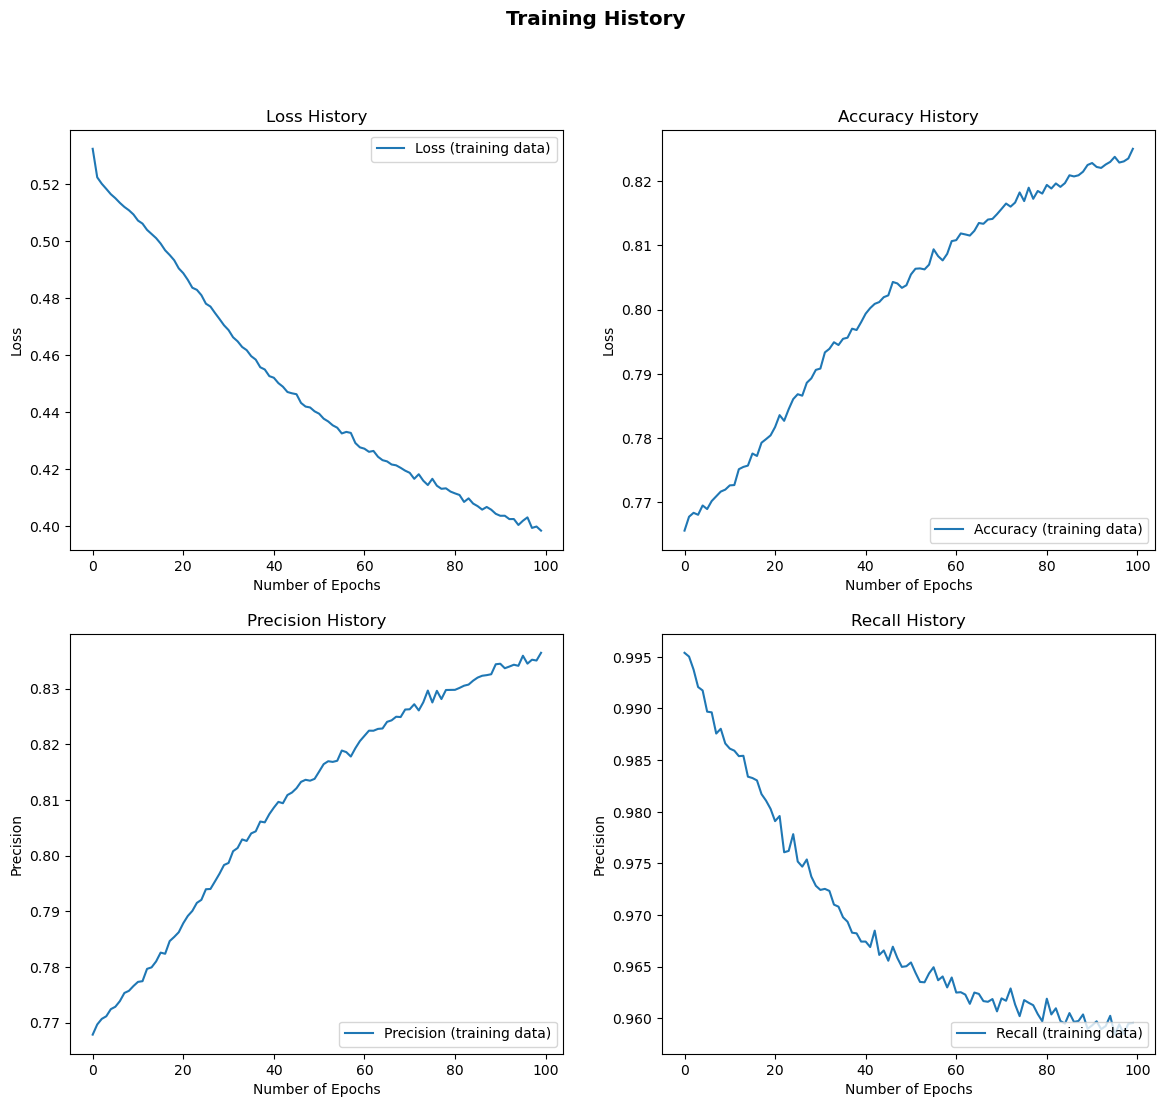

In [13]:
visualize_training_history(history)

1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


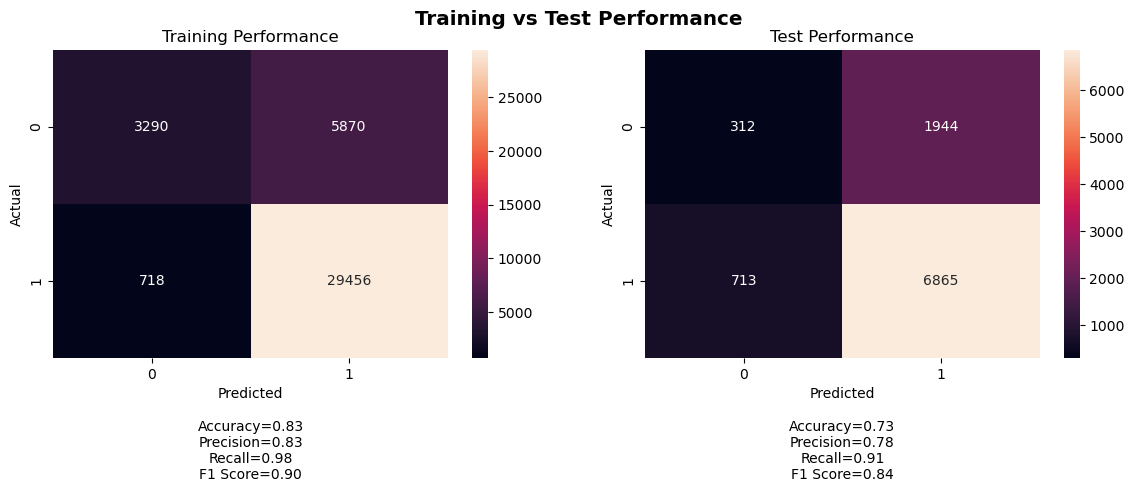

In [14]:
# Change probabilities to 0s and 1s
y_train_pred = (model.predict(X_train) >= 0.5).astype('int64')
y_test_pred = (model.predict(X_test) >= 0.5).astype('int64')

accuracy, precision, recall, f1_score = visualize_performance(y_train, y_train_pred, 
                                                              y_test, y_test_pred)

# Save values
tests_performance['Test Accuracy'].append(('Original', accuracy))
tests_performance['Test Precision'].append(('Original', precision))
tests_performance['Test Recall'].append(('Original', recall))
tests_performance['Test F1 Score' ].append(('Original', f1_score))

In [15]:
history = model.fit(X_train, y_train, batch_size=32, epochs=100)
training_histories['Oversampling'] = history

Epoch 1/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8249 - loss: 0.3954 - precision: 0.8350 - recall: 0.9611
Epoch 2/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8301 - loss: 0.3893 - precision: 0.8412 - recall: 0.9603
Epoch 3/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8254 - loss: 0.3929 - precision: 0.8367 - recall: 0.9595
Epoch 4/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8257 - loss: 0.3954 - precision: 0.8370 - recall: 0.9580
Epoch 5/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8288 - loss: 0.3871 - precision: 0.8409 - recall: 0.9586
Epoch 6/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8280 - loss: 0.3920 - precision: 0.8379 - recall: 0.9604
Epoch 7/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8288 - loss: 0.3878 - precision: 0.8387 - recall: 0.9622
Epoch 8/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8294 - loss: 0.3891 - precision: 0.8395 - recall:

1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8383 - loss: 0.3711 - precision: 0.8496 - recall: 0.9583
Epoch 52/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8370 - loss: 0.3719 - precision: 0.8488 - recall: 0.9572
Epoch 53/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8358 - loss: 0.3765 - precision: 0.8462 - recall: 0.9591
Epoch 54/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8369 - loss: 0.3730 - precision: 0.8489 - recall: 0.9581
Epoch 55/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8382 - loss: 0.3677 - precision: 0.8499 - recall: 0.9593
Epoch 56/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8382 - loss: 0.3706 - precision: 0.8491 - recall: 0.9596
Epoch 57/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8396 - loss: 0.3703 - precision: 0.8498 - recall: 0.9610
Epoch 58/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8419 - loss: 0.3637 - precision: 0.8523 - recall: 0.96

In [29]:
#Dense 1

weights = np.abs(model.layers[0].get_weights()[0]).mean(axis=0)
indices = np.argsort(weights)[::1]
weights = weights[indices][::1]

# Print the feature rankings
print("Ranking of variables that determine the loan status:")
for f in range(0, 45):
    print(f"{f+1}.{pred.columns[indices[f]]} ({weights[f]:.4f})")

Ranking of variables that determine the loan status:
1.Tax Liens_0 (0.3419)
2.Years in current job_7 years (0.3613)
3.Purpose_Educational Expenses (0.3800)
4.Years in current job_9 years (0.3871)
5.Purpose_Renewable Energy (0.3877)
6.Annual Income (0.3928)
7.Purpose_Home Improvements (0.3973)
8.Purpose_Buy a Car (0.3986)
9.Purpose_Moving (0.4011)
10.Current Loan Amount (0.4026)
11.Purpose_Vacation (0.4081)
12.Maximum Open Credit (0.4108)
13.Home Ownership_Rent (0.4115)
14.Current Credit Balance (0.4155)
15.Purpose_Major Purchase (0.4176)
16.Years of Credit History (0.4224)
17.Years in current job_10+ years (0.4254)
18.Home Ownership_Home Mortgage (0.4271)
19.Purpose_Business Loan (0.4277)
20.Home Ownership_Have Mortgage (0.4303)
21.Purpose_Other (0.4306)
22.Purpose_Medical Bills (0.4310)
23.Years in current job_3 years (0.4362)
24.Bankruptcies_>= 1 (0.4367)
25.Home Ownership_Own Home (0.4413)
26.Bankruptcies_0 (0.4436)
27.Purpose_Take a Trip (0.4444)
28.Years in current job_1 year (0.4

In [30]:
#Dense 2

weights = np.abs(model.layers[1].get_weights()[0]).mean(axis=0)
indices = np.argsort(weights)[::1]
weights = weights[indices][::1]

# Print the feature rankings
print("Ranking of variables that determine the loan status:")
for f in range(0, 45):
    print(f"{f+1}.{pred.columns[indices[f]]} ({weights[f]:.4f})")

Ranking of variables that determine the loan status:
1.Years in current job_2 years (0.3213)
2.Term_Long Term (0.3246)
3.Years in current job_1 year (0.3426)
4.Tax Liens_>= 1 (0.3803)
5.Bankruptcies_0 (0.3965)
6.Purpose_Business Loan (0.3970)
7.Purpose_Buy House (0.4087)
8.Current Credit Balance (0.4114)
9.Years in current job_4 years (0.4168)
10.Years in current job_10+ years (0.4389)
11.Purpose_Moving (0.4459)
12.Purpose_Educational Expenses (0.4552)
13.Purpose_Vacation (0.4554)
14.Purpose_Debt Consolidation (0.4594)
15.Purpose_Medical Bills (0.4629)
16.Purpose_Take a Trip (0.4681)
17.Home Ownership_Own Home (0.4732)
18.Years in current job_3 years (0.4781)
19.Purpose_Major Purchase (0.4934)
20.Years of Credit History (0.4938)
21.Number of Credit Problems_>= 1 (0.5017)
22.Term_Short Term (0.5020)
23.Maximum Open Credit (0.5073)
24.Bankruptcies_>= 1 (0.5164)
25.Monthly Debt (0.5177)
26.Years in current job_8 years (0.5397)
27.Tax Liens_0 (0.5472)
28.Annual Income (0.5507)
29.Years in 

In [31]:
#Dense 3

weights = np.abs(model.layers[2].get_weights()[0]).mean(axis=0)
indices = np.argsort(weights)[::1]
weights = weights[indices][::1]

# Print the feature rankings
print("Ranking of variables that determine the loan status:")
for f in range(0, 45):
    print(f"{f+1}.{pred.columns[indices[f]]} ({weights[f]:.4f})")

Ranking of variables that determine the loan status:
1.Bankruptcies_>= 1 (0.4294)
2.Home Ownership_Own Home (0.4701)
3.Years in current job_2 years (0.4828)
4.Purpose_Moving (0.4914)
5.Years in current job_1 year (0.4988)
6.Purpose_Educational Expenses (0.5446)
7.Years in current job_9 years (0.5492)
8.Annual Income (0.5631)
9.Home Ownership_Rent (0.5642)
10.Purpose_Renewable Energy (0.5685)
11.Years in current job_6 years (0.5735)
12.Years in current job_4 years (0.5755)
13.Purpose_Small Business (0.5780)
14.Years in current job_< 1 year (0.5876)
15.Years of Credit History (0.5943)
16.Years in current job_10+ years (0.5974)
17.Purpose_Medical Bills (0.6004)
18.Current Credit Balance (0.6024)
19.Purpose_Other (0.6073)
20.Tax Liens_0 (0.6121)
21.Years in current job_7 years (0.6179)
22.Home Ownership_Have Mortgage (0.6228)
23.Number of Credit Problems_>= 1 (0.6343)
24.Tax Liens_>= 1 (0.6344)
25.Years in current job_8 years (0.6349)
26.Home Ownership_Home Mortgage (0.6441)
27.Years in cu

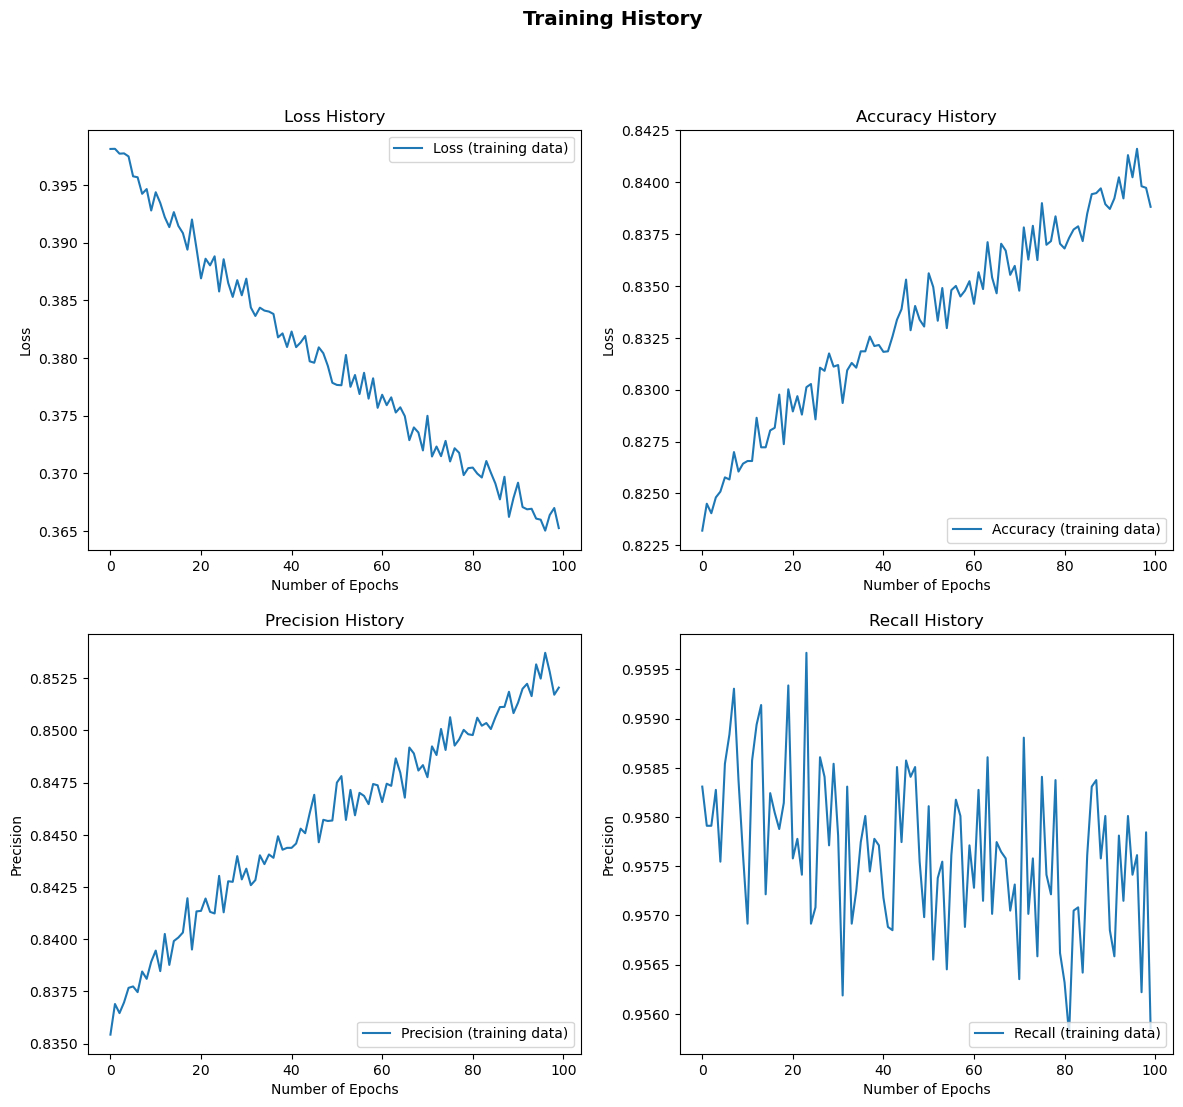

In [19]:
visualize_training_history(history)

1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


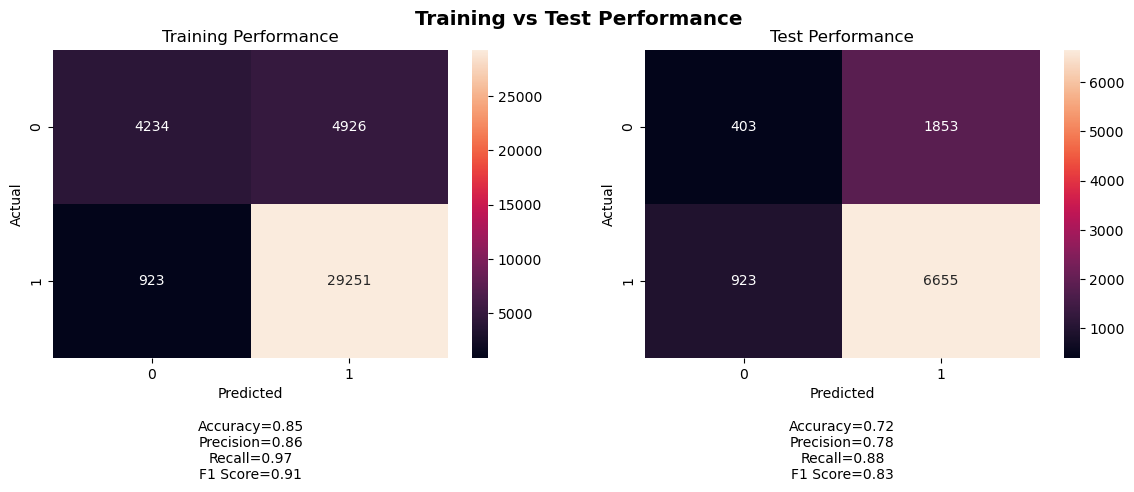

In [20]:
# Change probabilities to 0s and 1s
y_train_pred = (model.predict(X_train) >= 0.5).astype('int64')
y_test_pred = (model.predict(X_test) >= 0.5).astype('int64')

accuracy, precision, recall, f1_score = visualize_performance(y_train, y_train_pred, 
                                                              y_test, y_test_pred)

# Save values
tests_performance['Test Accuracy'].append(('Oversampling', accuracy))
tests_performance['Test Precision'].append(('Oversampling', precision))
tests_performance['Test Recall'].append(('Oversampling', recall))
tests_performance['Test F1 Score' ].append(('Oversampling', f1_score))

In [35]:
history = model.fit(X_train, y_train, batch_size=32, epochs=100)
training_histories['SMOTETomek'] = history

Epoch 1/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8503 - loss: 0.3498 - precision: 0.8587 - recall: 0.9648
Epoch 2/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8504 - loss: 0.3488 - precision: 0.8587 - recall: 0.9636
Epoch 3/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8502 - loss: 0.3462 - precision: 0.8593 - recall: 0.9629
Epoch 4/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8485 - loss: 0.3506 - precision: 0.8579 - recall: 0.9606
Epoch 5/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8517 - loss: 0.3433 - precision: 0.8605 - recall: 0.9639
Epoch 6/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8519 - loss: 0.3432 - precision: 0.8610 - recall: 0.9630
Epoch 7/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8527 - loss: 0.3434 - precision: 0.8614 - recall: 0.9640
Epoch 8/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8498 - loss: 0.3447 - precision: 0.8601 - recall:

1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8531 - loss: 0.3343 - precision: 0.8647 - recall: 0.9583
Epoch 52/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8555 - loss: 0.3354 - precision: 0.8663 - recall: 0.9596
Epoch 53/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8533 - loss: 0.3355 - precision: 0.8651 - recall: 0.9587
Epoch 54/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8522 - loss: 0.3404 - precision: 0.8650 - recall: 0.9570
Epoch 55/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8492 - loss: 0.3416 - precision: 0.8619 - recall: 0.9560
Epoch 56/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8562 - loss: 0.3363 - precision: 0.8670 - recall: 0.9605
Epoch 57/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8546 - loss: 0.3345 - precision: 0.8647 - recall: 0.9605
Epoch 58/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8551 - loss: 0.3341 - precision: 0.8666 - recall: 0.95

In [36]:
#Dense 1

weights = np.abs(model.layers[0].get_weights()[0]).mean(axis=0)
indices = np.argsort(weights)[::1]
weights = weights[indices][::1]

# Print the feature rankings
print("Ranking of variables that determine the loan status:")
for f in range(0, 45):
    print(f"{f+1}.{pred.columns[indices[f]]} ({weights[f]:.4f})")

Ranking of variables that determine the loan status:
1.Tax Liens_0 (0.3821)
2.Years in current job_7 years (0.4251)
3.Current Loan Amount (0.4277)
4.Purpose_Educational Expenses (0.4376)
5.Purpose_Renewable Energy (0.4387)
6.Purpose_Home Improvements (0.4400)
7.Annual Income (0.4421)
8.Years in current job_9 years (0.4457)
9.Purpose_Vacation (0.4493)
10.Purpose_Buy a Car (0.4635)
11.Purpose_Moving (0.4662)
12.Years of Credit History (0.4678)
13.Home Ownership_Have Mortgage (0.4709)
14.Purpose_Medical Bills (0.4743)
15.Home Ownership_Rent (0.4754)
16.Maximum Open Credit (0.4766)
17.Purpose_Major Purchase (0.4779)
18.Current Credit Balance (0.4787)
19.Home Ownership_Home Mortgage (0.4801)
20.Years in current job_10+ years (0.4860)
21.Years in current job_3 years (0.4863)
22.Purpose_Business Loan (0.4892)
23.Purpose_Other (0.4916)
24.Bankruptcies_0 (0.4926)
25.Bankruptcies_>= 1 (0.4995)
26.Credit Score (0.5018)
27.Monthly Debt (0.5024)
28.Home Ownership_Own Home (0.5027)
29.Purpose_Take a

In [37]:
#Dense 2

weights = np.abs(model.layers[1].get_weights()[0]).mean(axis=0)
indices = np.argsort(weights)[::1]
weights = weights[indices][::1]

# Print the feature rankings
print("Ranking of variables that determine the loan status:")
for f in range(0, 45):
    print(f"{f+1}.{pred.columns[indices[f]]} ({weights[f]:.4f})")

Ranking of variables that determine the loan status:
1.Years in current job_2 years (0.3566)
2.Term_Long Term (0.3616)
3.Years in current job_1 year (0.3733)
4.Tax Liens_>= 1 (0.4179)
5.Bankruptcies_0 (0.4372)
6.Purpose_Business Loan (0.4378)
7.Purpose_Buy House (0.4525)
8.Current Credit Balance (0.4540)
9.Years in current job_4 years (0.4640)
10.Purpose_Moving (0.4941)
11.Years in current job_10+ years (0.4953)
12.Purpose_Educational Expenses (0.5053)
13.Purpose_Vacation (0.5115)
14.Purpose_Debt Consolidation (0.5154)
15.Home Ownership_Own Home (0.5218)
16.Purpose_Take a Trip (0.5261)
17.Purpose_Medical Bills (0.5273)
18.Years in current job_3 years (0.5338)
19.Purpose_Major Purchase (0.5461)
20.Years of Credit History (0.5488)
21.Maximum Open Credit (0.5705)
22.Term_Short Term (0.5777)
23.Number of Credit Problems_>= 1 (0.5801)
24.Monthly Debt (0.5842)
25.Years in current job_7 years (0.6049)
26.Years in current job_8 years (0.6059)
27.Bankruptcies_>= 1 (0.6160)
28.Years in current j

In [38]:
#Dense 3

weights = np.abs(model.layers[2].get_weights()[0]).mean(axis=0)
indices = np.argsort(weights)[::1]
weights = weights[indices][::1]

# Print the feature rankings
print("Ranking of variables that determine the loan status:")
for f in range(0, 45):
    print(f"{f+1}.{pred.columns[indices[f]]} ({weights[f]:.4f})")

Ranking of variables that determine the loan status:
1.Bankruptcies_>= 1 (0.4877)
2.Home Ownership_Own Home (0.5279)
3.Years in current job_2 years (0.5482)
4.Years in current job_1 year (0.5573)
5.Purpose_Moving (0.5816)
6.Purpose_Educational Expenses (0.6097)
7.Years in current job_9 years (0.6292)
8.Home Ownership_Rent (0.6293)
9.Years in current job_4 years (0.6388)
10.Years in current job_6 years (0.6446)
11.Purpose_Renewable Energy (0.6462)
12.Purpose_Medical Bills (0.6598)
13.Years in current job_< 1 year (0.6609)
14.Annual Income (0.6618)
15.Purpose_Small Business (0.6830)
16.Years of Credit History (0.6855)
17.Years in current job_10+ years (0.6962)
18.Home Ownership_Home Mortgage (0.7111)
19.Number of Credit Problems_>= 1 (0.7125)
20.Home Ownership_Have Mortgage (0.7142)
21.Tax Liens_0 (0.7248)
22.Years in current job_7 years (0.7287)
23.Tax Liens_>= 1 (0.7329)
24.Purpose_Other (0.7365)
25.Current Credit Balance (0.7380)
26.Years in current job_8 years (0.7406)
27.Years in cu

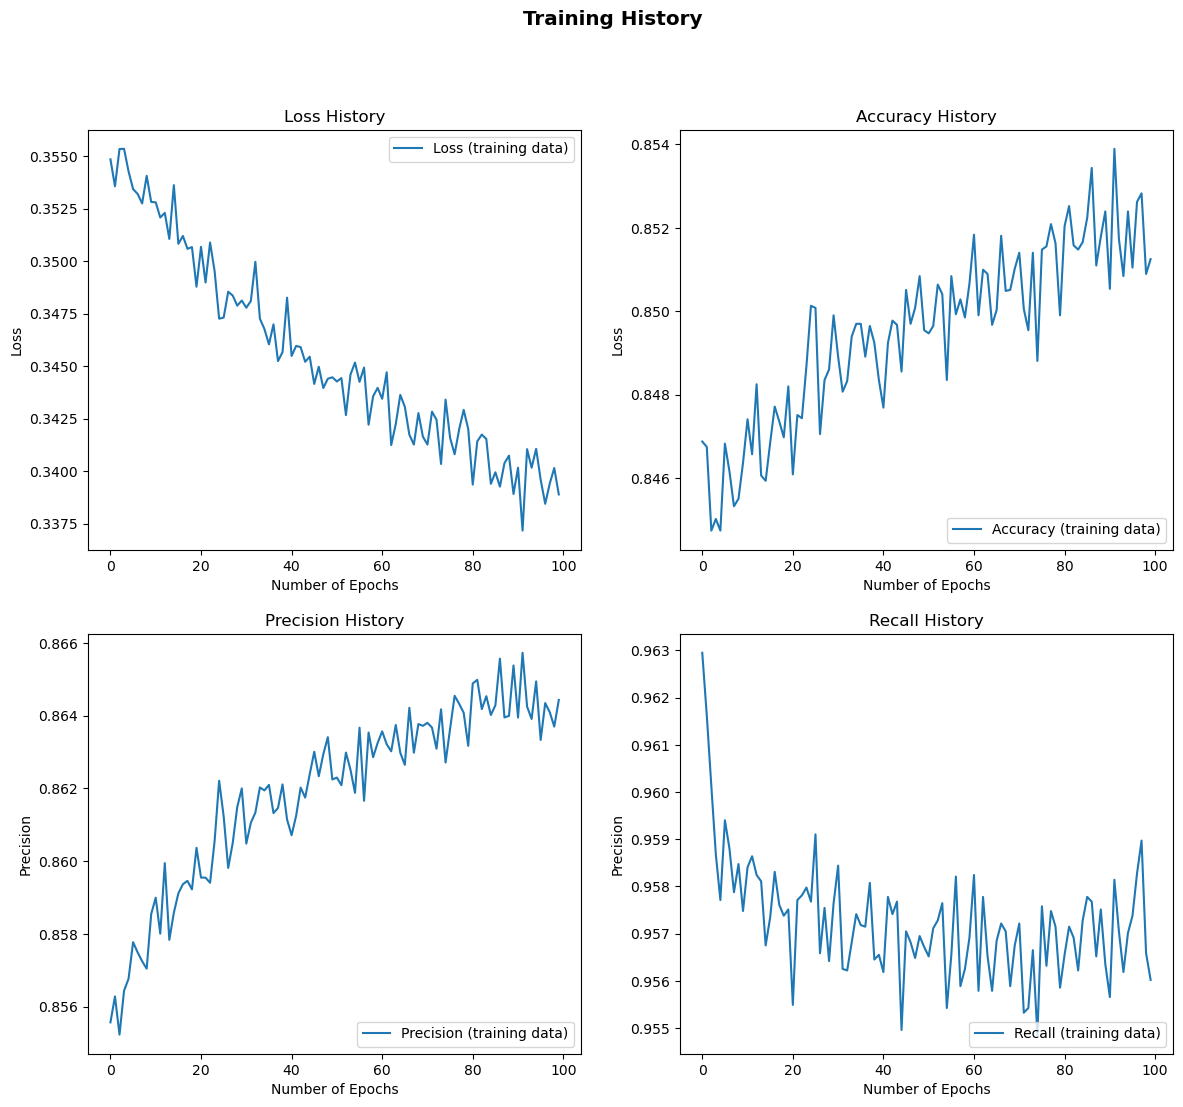

In [39]:
visualize_training_history(history)

1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


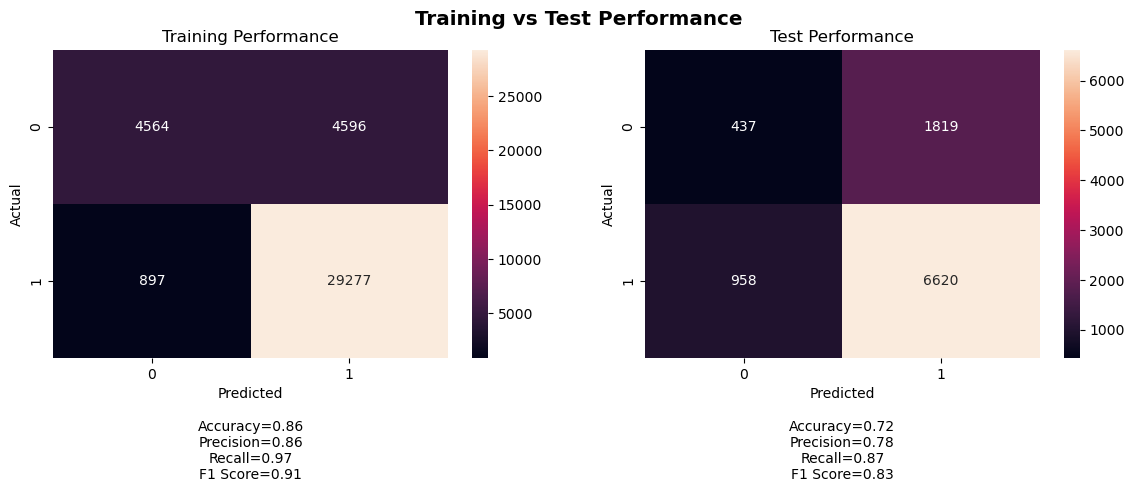

In [40]:
# Change probabilities to 0s and 1s
y_train_pred = (model.predict(X_train) >= 0.5).astype('int64')
y_test_pred = (model.predict(X_test) >= 0.5).astype('int64')

accuracy, precision, recall, f1_score = visualize_performance(y_train, y_train_pred, 
                                                              y_test, y_test_pred)

# Save values
tests_performance['Test Accuracy'].append(('SMOTETomek', accuracy))
tests_performance['Test Precision'].append(('SMOTETomek', precision))
tests_performance['Test Recall'].append(('SMOTETomek', recall))
tests_performance['Test F1 Score' ].append(('SMOTETomek', f1_score))

In [41]:
history = model.fit(X_train, y_train, batch_size=32, epochs=100)
training_histories['SMOTEENN'] = history

Epoch 1/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8545 - loss: 0.3335 - precision: 0.8655 - recall: 0.9587
Epoch 2/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8581 - loss: 0.3298 - precision: 0.8676 - recall: 0.9627
Epoch 3/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8558 - loss: 0.3320 - precision: 0.8674 - recall: 0.9584
Epoch 4/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8546 - loss: 0.3349 - precision: 0.8657 - recall: 0.9601
Epoch 5/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8617 - loss: 0.3279 - precision: 0.8718 - recall: 0.9622
Epoch 6/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8546 - loss: 0.3334 - precision: 0.8654 - recall: 0.9580
Epoch 7/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8569 - loss: 0.3350 - precision: 0.8662 - recall: 0.9618
Epoch 8/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8582 - loss: 0.3288 - precision: 0.8700 - recall:

1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8603 - loss: 0.3252 - precision: 0.8703 - recall: 0.9604
Epoch 52/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8569 - loss: 0.3300 - precision: 0.8680 - recall: 0.9588
Epoch 53/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8614 - loss: 0.3207 - precision: 0.8709 - recall: 0.9619
Epoch 54/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8620 - loss: 0.3223 - precision: 0.8727 - recall: 0.9601
Epoch 55/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8591 - loss: 0.3198 - precision: 0.8709 - recall: 0.9600
Epoch 56/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8588 - loss: 0.3283 - precision: 0.8700 - recall: 0.9597
Epoch 57/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8609 - loss: 0.3254 - precision: 0.8720 - recall: 0.9599
Epoch 58/100
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8587 - loss: 0.3242 - precision: 0.8701 - recall: 0.95

In [42]:
#Dense 1

weights = np.abs(model.layers[0].get_weights()[0]).mean(axis=0)
indices = np.argsort(weights)[::1]
weights = weights[indices][::1]

# Print the feature rankings
print("Ranking of variables that determine the loan status:")
for f in range(0, 45):
    print(f"{f+1}.{pred.columns[indices[f]]} ({weights[f]:.4f})")

Ranking of variables that determine the loan status:
1.Tax Liens_0 (0.4107)
2.Current Loan Amount (0.4588)
3.Years in current job_7 years (0.4645)
4.Purpose_Home Improvements (0.4746)
5.Purpose_Renewable Energy (0.4781)
6.Purpose_Educational Expenses (0.4810)
7.Purpose_Vacation (0.4831)
8.Annual Income (0.4889)
9.Years of Credit History (0.4971)
10.Years in current job_9 years (0.5002)
11.Purpose_Buy a Car (0.5032)
12.Home Ownership_Have Mortgage (0.5115)
13.Purpose_Major Purchase (0.5136)
14.Purpose_Medical Bills (0.5143)
15.Purpose_Moving (0.5151)
16.Maximum Open Credit (0.5172)
17.Home Ownership_Home Mortgage (0.5246)
18.Years in current job_3 years (0.5287)
19.Bankruptcies_0 (0.5307)
20.Home Ownership_Rent (0.5331)
21.Purpose_Other (0.5348)
22.Current Credit Balance (0.5371)
23.Bankruptcies_>= 1 (0.5413)
24.Purpose_Business Loan (0.5414)
25.Years in current job_10+ years (0.5419)
26.Credit Score (0.5443)
27.Monthly Debt (0.5483)
28.Home Ownership_Own Home (0.5491)
29.Term_Long Term

In [44]:
#Dense 2

weights = np.abs(model.layers[1].get_weights()[0]).mean(axis=0)
indices = np.argsort(weights)[::1]
weights = weights[indices][::1]

# Print the feature rankings
print("Ranking of variables that determine the loan status:")
for f in range(0, 45):
    print(f"{f+1}.{pred.columns[indices[f]]} ({weights[f]:.4f})")

Ranking of variables that determine the loan status:
1.Years in current job_2 years (0.3741)
2.Term_Long Term (0.4006)
3.Years in current job_1 year (0.4011)
4.Tax Liens_>= 1 (0.4522)
5.Bankruptcies_0 (0.4751)
6.Purpose_Business Loan (0.4770)
7.Years in current job_4 years (0.4864)
8.Current Credit Balance (0.4898)
9.Purpose_Buy House (0.4923)
10.Purpose_Moving (0.5253)
11.Purpose_Educational Expenses (0.5536)
12.Purpose_Vacation (0.5541)
13.Purpose_Take a Trip (0.5542)
14.Years in current job_10+ years (0.5570)
15.Purpose_Debt Consolidation (0.5576)
16.Home Ownership_Own Home (0.5654)
17.Years in current job_3 years (0.5856)
18.Purpose_Medical Bills (0.5865)
19.Purpose_Major Purchase (0.5933)
20.Years of Credit History (0.6074)
21.Maximum Open Credit (0.6153)
22.Term_Short Term (0.6371)
23.Monthly Debt (0.6379)
24.Number of Credit Problems_>= 1 (0.6439)
25.Years in current job_7 years (0.6516)
26.Years in current job_8 years (0.6602)
27.Bankruptcies_>= 1 (0.6748)
28.Tax Liens_0 (0.685

In [45]:
#Dense 3

weights = np.abs(model.layers[2].get_weights()[0]).mean(axis=0)
indices = np.argsort(weights)[::1]
weights = weights[indices][::1]

# Print the feature rankings
print("Ranking of variables that determine the loan status:")
for f in range(0, 45):
    print(f"{f+1}.{pred.columns[indices[f]]} ({weights[f]:.4f})")

Ranking of variables that determine the loan status:
1.Bankruptcies_>= 1 (0.5195)
2.Home Ownership_Own Home (0.5584)
3.Years in current job_1 year (0.5922)
4.Years in current job_2 years (0.6013)
5.Years in current job_9 years (0.6618)
6.Home Ownership_Rent (0.6627)
7.Purpose_Moving (0.6826)
8.Purpose_Educational Expenses (0.6836)
9.Purpose_Renewable Energy (0.6837)
10.Years in current job_6 years (0.6844)
11.Years in current job_4 years (0.6940)
12.Purpose_Medical Bills (0.7095)
13.Annual Income (0.7166)
14.Years of Credit History (0.7414)
15.Years in current job_< 1 year (0.7440)
16.Purpose_Small Business (0.7598)
17.Number of Credit Problems_>= 1 (0.7640)
18.Years in current job_10+ years (0.7708)
19.Home Ownership_Home Mortgage (0.7777)
20.Home Ownership_Have Mortgage (0.8032)
21.Purpose_Other (0.8084)
22.Years in current job_7 years (0.8129)
23.Tax Liens_0 (0.8229)
24.Years in current job_5 years (0.8320)
25.Purpose_Take a Trip (0.8323)
26.Years in current job_8 years (0.8354)
27.

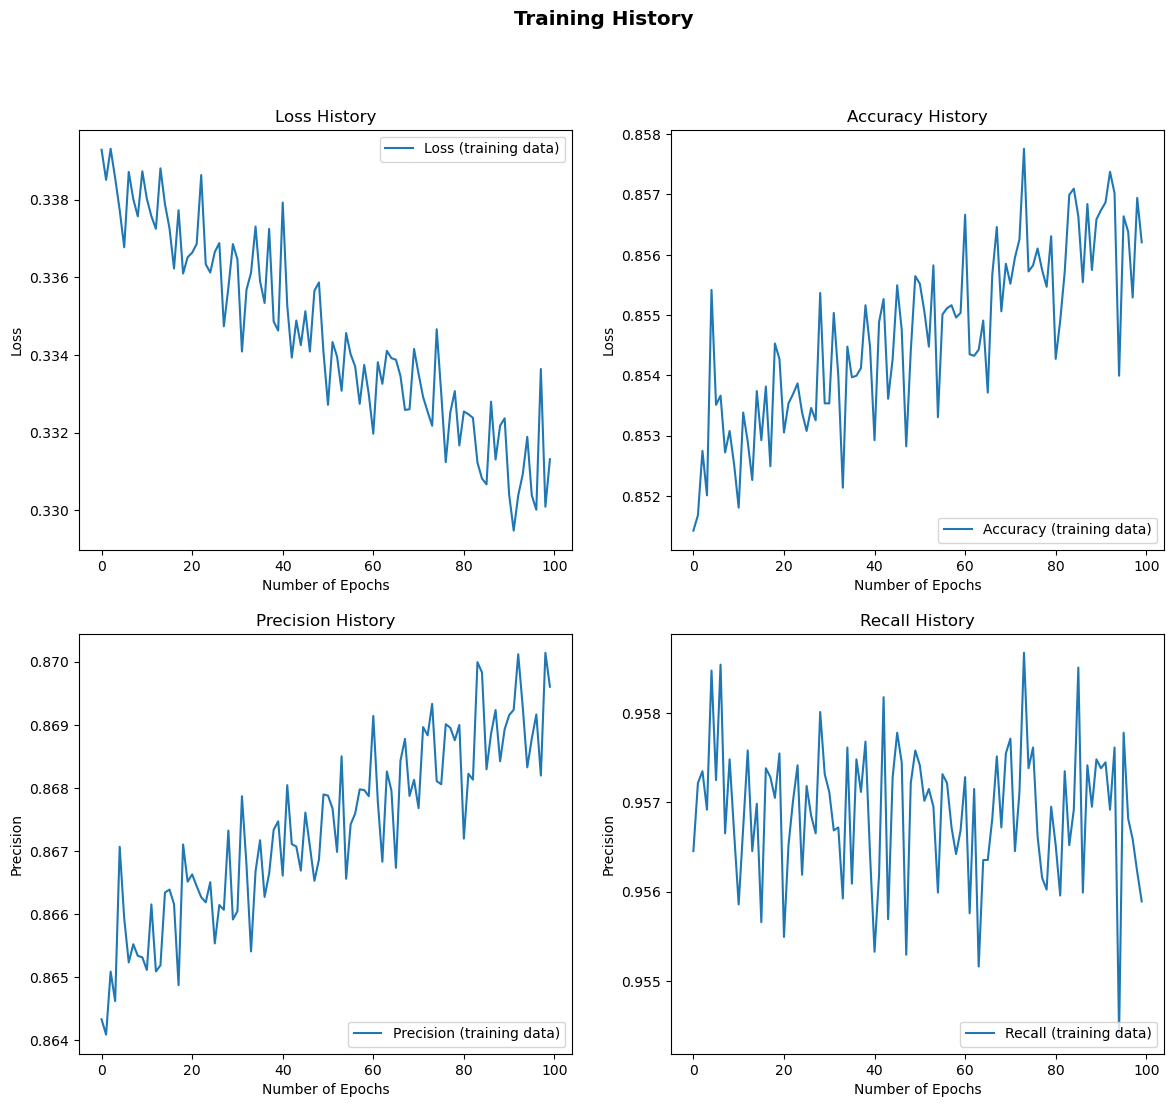

In [46]:
visualize_training_history(history)

1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


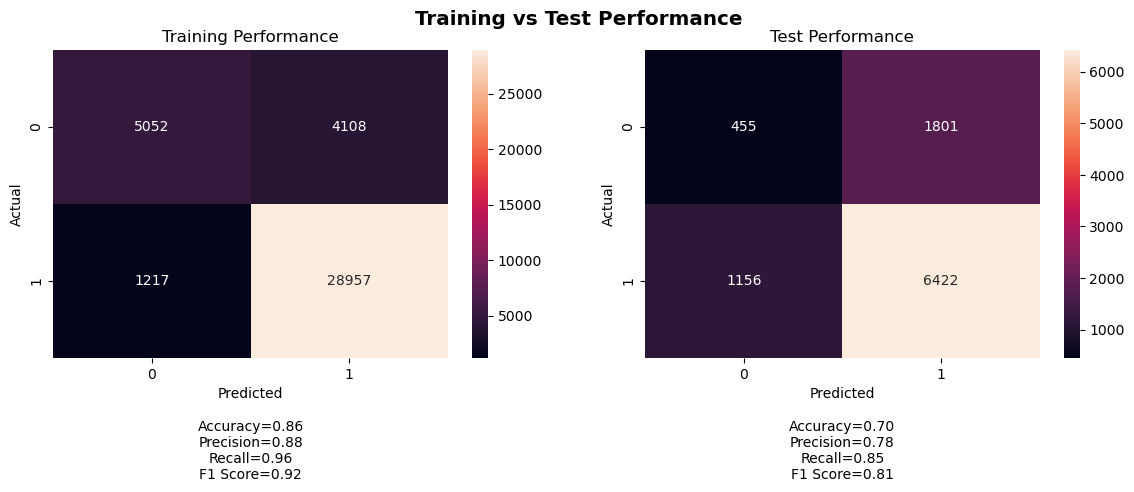

In [47]:
# Change probabilities to 0s and 1s
y_train_pred = (model.predict(X_train) >= 0.5).astype('int64')
y_test_pred = (model.predict(X_test) >= 0.5).astype('int64')

accuracy, precision, recall, f1_score = visualize_performance(y_train, y_train_pred, 
                                                              y_test, y_test_pred)

# Save values
tests_performance['Test Accuracy'].append(('SMOTEENN', accuracy))
tests_performance['Test Precision'].append(('SMOTEENN', precision))
tests_performance['Test Recall'].append(('SMOTEENN', recall))
tests_performance['Test F1 Score' ].append(('SMOTEENN', f1_score))

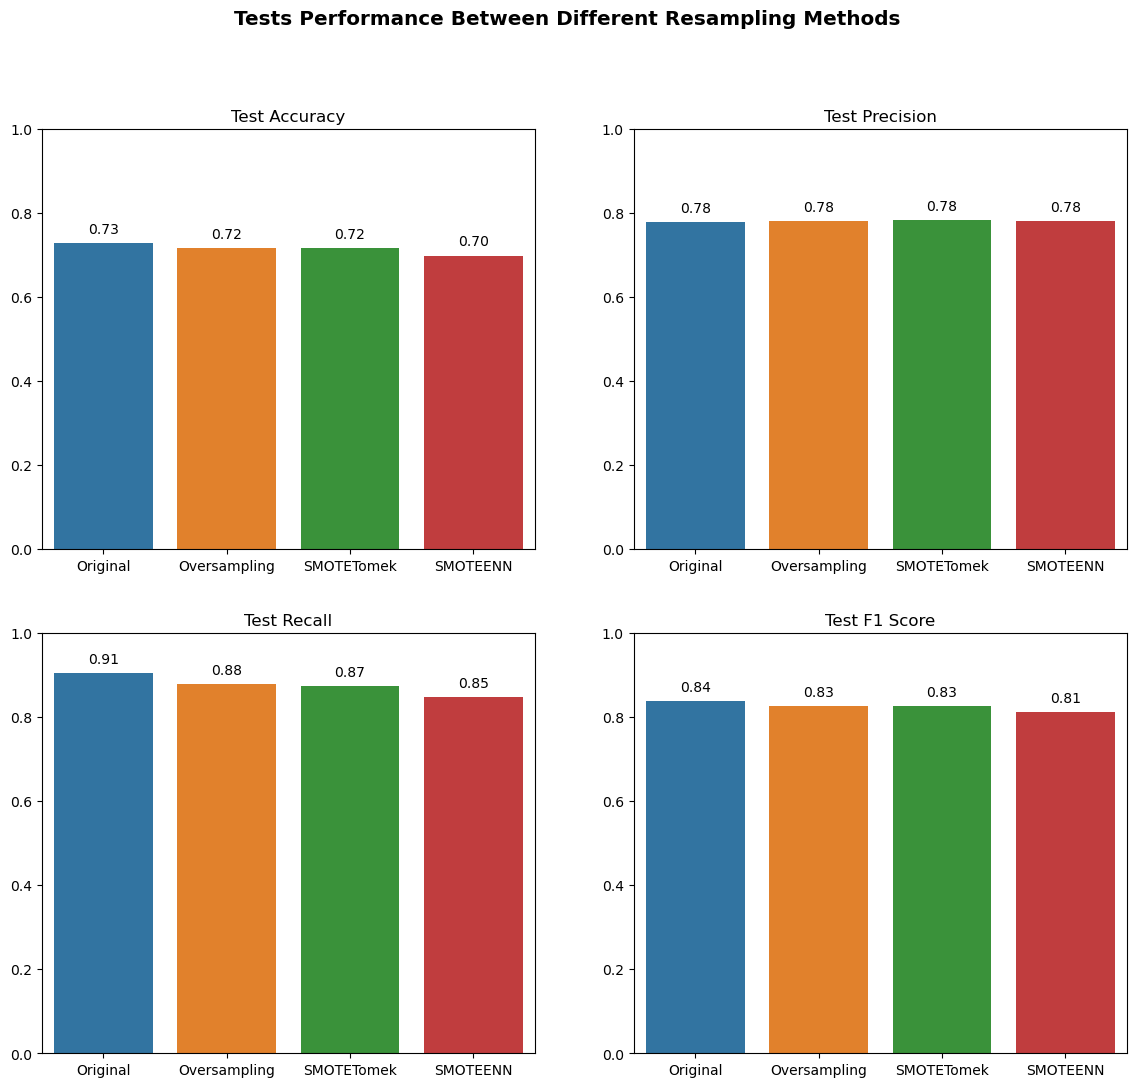

In [48]:
visualize_tests_performance(tests_performance)

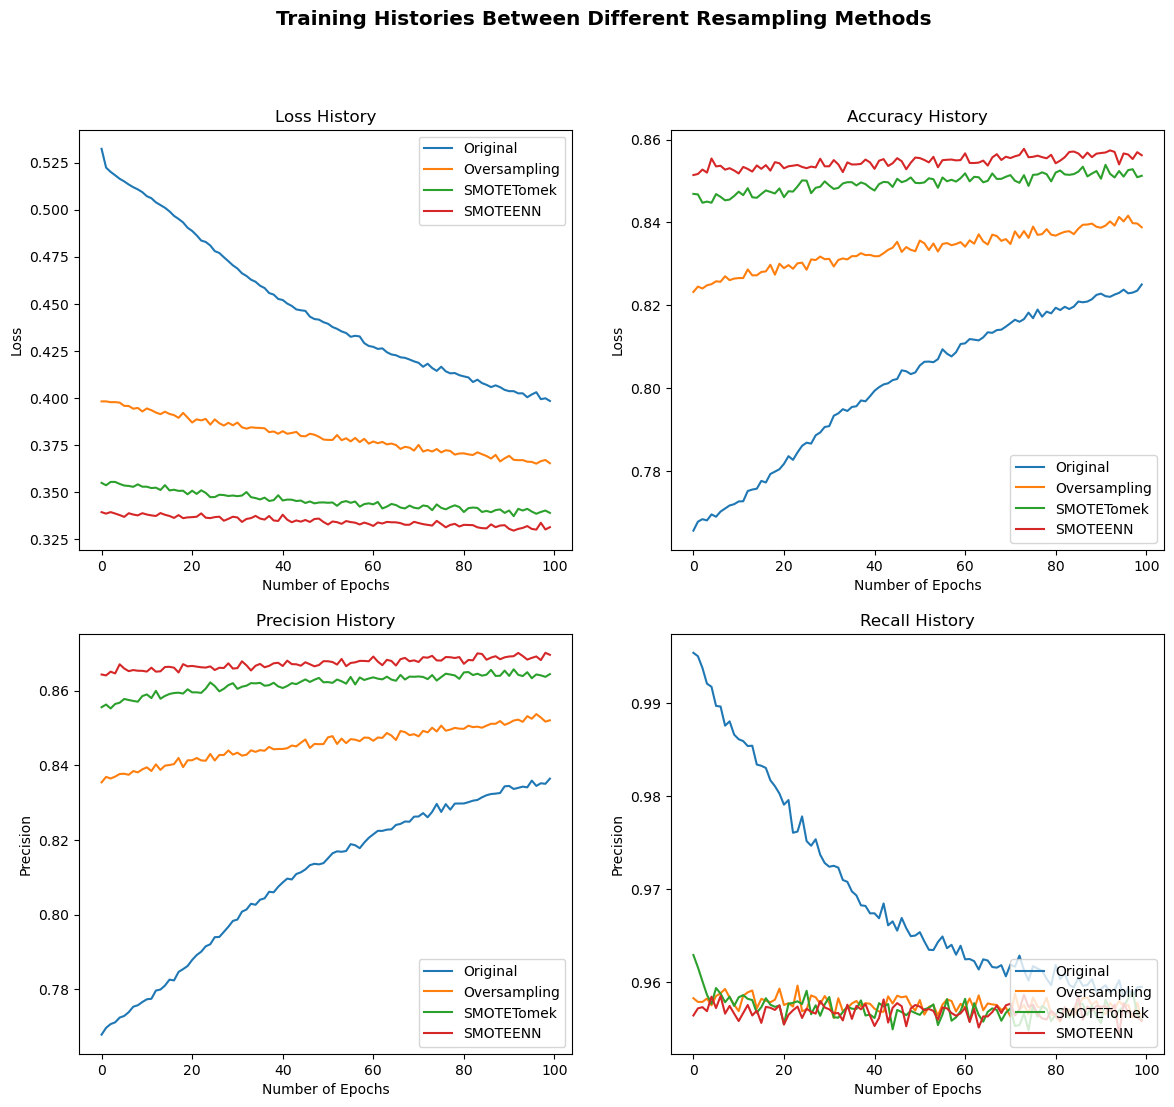

In [49]:
visualize_multiple_training_histories(training_histories)